In [1]:
!pip install h5py
!pip install tensorflow

In [2]:
# Import useful libraries
import pandas as pd
import json
import numpy as np
from scipy.stats.stats import mode
import seaborn as sns
from PIL import Image
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, normalize, StandardScaler

# Classifier models
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict, GridSearchCV 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report


# Statistic libraries
from scipy.optimize import fmin, minimize_scalar
from scipy import stats

# Importing Keras library from Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers.merge import Concatenate
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.python.keras.layers.core import Dense
from tensorflow.python.keras.layers.pooling import GlobalAveragePooling2D
from keras.models import load_model
from os import makedirs

In [3]:
from app import EvaluateAndReport, add_features, plot_features, to_RGB, get_distrib, DeepLearningExplore

In [4]:
# Import Google Drive
from google.colab import drive
drive.mount('/content/drive')

#returns JSON object as a dictionary
f = open('/content/drive/MyDrive/Iceberg/train.json',) # The train.json file needs to be in an "Iceberg" directory

# creating a dataframe
df_raw = pd.DataFrame(json.load(f))

# visualising the first rows
df_raw.head()

Mounted at /content/drive


,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878361, -27.15416, -28.668615, -29.537971...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920305, -14.920363, -12.66633...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


In [5]:
# Visualising info
print(df_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          1604 non-null   object
 1   band_1      1604 non-null   object
 2   band_2      1604 non-null   object
 3   inc_angle   1604 non-null   object
 4   is_iceberg  1604 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 62.8+ KB
None


In [6]:
# Train/test split for the whole project as we don't have a test dataset
df = df_raw.sample(frac = 0.8, random_state = 42)
df_test = df_raw.drop(df.index)
# Changing inc_angle from object to float64
df.replace('na', np.NaN, inplace = True) # Replacing the 'na' text in inc_angle by NaN
df['inc_angle'].astype('float', copy = False) # Casting inc_angle to float works with the NaN
df[df.inc_angle.isna()] # 133 NaN
print(df.info()) # inc_angle is now float64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1283 entries, 530 to 546
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          1283 non-null   object 
 1   band_1      1283 non-null   object 
 2   band_2      1283 non-null   object 
 3   inc_angle   1175 non-null   float64
 4   is_iceberg  1283 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 60.1+ KB
None


In [7]:
X_b1=np.array(
    [np.array(band).astype(np.float64).reshape(75, 75) for band in df["band_1"]]
    )

X_b2=np.array(
    [np.array(band).astype(np.float64).reshape(75, 75) for band in df["band_2"]]
    )

train_cnn = np.concatenate([X_b1[:, :, :, np.newaxis], X_b2[:, :, :, np.newaxis]], axis=-1)
target_cnn=df['is_iceberg']

In [8]:
from sklearn.model_selection import train_test_split

X_train_cnn, X_valid_cnn, y_train_cnn, y_valid_cnn = train_test_split(train_cnn, target_cnn, random_state=42, train_size=0.7)

# First Model

In [9]:
covnet = DeepLearningExplore(df, X_train_cnn, X_valid_cnn, y_train_cnn, y_valid_cnn, batch_s = 22)
cv_1 = covnet.create_model(2, 3)

Epoch 1/200
41/41 [==============================] - ETA: 0s - loss: 0.8910 - binary_accuracy: 0.5434
Epoch 00001: val_binary_accuracy improved from -inf to 0.45974, saving model to best_weights_110_.hdf5
41/41 [==============================] - 15s 42ms/step - loss: 0.8910 - binary_accuracy: 0.5434 - val_loss: 3.0117 - val_binary_accuracy: 0.4597
Epoch 2/200
39/41 [===========================>..] - ETA: 0s - loss: 0.7779 - binary_accuracy: 0.5769
Epoch 00002: val_binary_accuracy improved from 0.45974 to 0.54026, saving model to best_weights_110_.hdf5
41/41 [==============================] - 1s 27ms/step - loss: 0.7770 - binary_accuracy: 0.5791 - val_loss: 1.5022 - val_binary_accuracy: 0.5403
Epoch 3/200
39/41 [===========================>..] - ETA: 0s - loss: 0.7468 - binary_accuracy: 0.5723
Epoch 00003: val_binary_accuracy did not improve from 0.54026
41/41 [==============================] - 1s 23ms/step - loss: 0.7483 - binary_accuracy: 0.5735 - val_loss: 0.9271 - val_binary_accurac

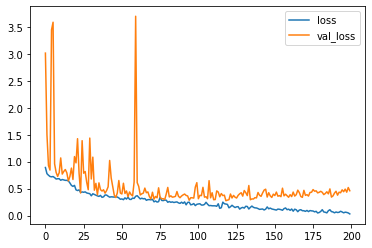

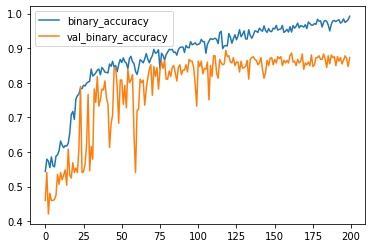

In [10]:
covnet.get_best_trained(cv_1, 200, verbose = True)

In [11]:
tf.keras.utils.plot_model(cv_1)
cv_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 75, 75, 2)         0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 75, 75, 2)         0         
                                                                 
 conv2d (Conv2D)             (None, 75, 75, 32)        1632      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 37, 37, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 18, 18, 64)       0         
 2D)                                                    

Epoch 1/100
39/41 [===========================>..] - ETA: 0s - loss: 0.8503 - binary_accuracy: 0.5291
Epoch 00001: val_binary_accuracy improved from -inf to 0.54026, saving model to best_weights_43_.hdf5
41/41 [==============================] - 3s 32ms/step - loss: 0.8495 - binary_accuracy: 0.5267 - val_loss: 4.9634 - val_binary_accuracy: 0.5403
Epoch 2/100
40/41 [============================>.] - ETA: 0s - loss: 0.7048 - binary_accuracy: 0.5739
Epoch 00002: val_binary_accuracy did not improve from 0.54026
41/41 [==============================] - 1s 22ms/step - loss: 0.7070 - binary_accuracy: 0.5702 - val_loss: 1.1041 - val_binary_accuracy: 0.5403
Epoch 3/100
40/41 [============================>.] - ETA: 0s - loss: 0.7083 - binary_accuracy: 0.5659
Epoch 00003: val_binary_accuracy did not improve from 0.54026
41/41 [==============================] - 1s 22ms/step - loss: 0.7110 - binary_accuracy: 0.5646 - val_loss: 0.7328 - val_binary_accuracy: 0.4597
Epoch 4/100
40/41 [=================

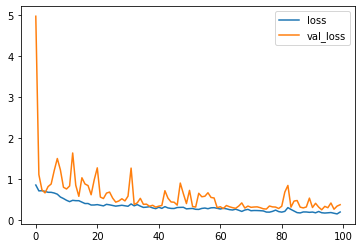

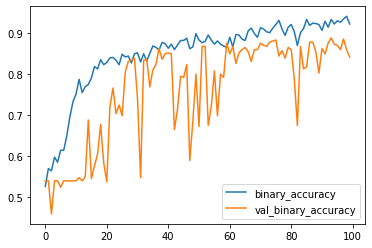

In [17]:
cv_2 = covnet.create_model(2, 1, drop_cv2D= True, normalization = True)
covnet.get_best_trained(cv_2, 100, verbose = True)

In [13]:
#cv_2.summary()

In [14]:
#cv_3 = covnet.create_model(4, 4, drop_cv2D= True, normalization = True)
#covnet.get_best_trained(cv_3, 100, verbose = True)

In [15]:
#covnet.get_other_metrics(model = cv_2)

>>>>>>>>>>> fit no : 0 done
>>>>>>>>>>> fit no : 1 done
>>>>>>>>>>> fit no : 2 done
>>>>>>>>>>> fit no : 3 done
>>>>>>>>>>> fit no : 4 done
>>>>>>>>>>> fit no : 5 done
>>>>>>>>>>> fit no : 6 done
>>>>>>>>>>> fit no : 7 done
>>>>>>>>>>> fit no : 8 done
>>>>>>>>>>> fit no : 9 done
>>>>>>>>>>> fit no : 10 done
>>>>>>>>>>> fit no : 11 done
>>>>>>>>>>> fit no : 12 done
>>>>>>>>>>> fit no : 13 done
>>>>>>>>>>> fit no : 14 done
>>>>>>>>>>> fit no : 15 done
>>>>>>>>>>> fit no : 16 done
>>>>>>>>>>> fit no : 17 done
>>>>>>>>>>> fit no : 18 done
>>>>>>>>>>> fit no : 19 done
>>>>>>>>>>> fit no : 20 done
>>>>>>>>>>> fit no : 21 done
>>>>>>>>>>> fit no : 22 done
>>>>>>>>>>> fit no : 23 done
>>>>>>>>>>> fit no : 24 done
>>>>>>>>>>> fit no : 25 done
>>>>>>>>>>> fit no : 26 done
>>>>>>>>>>> fit no : 27 done
>>>>>>>>>>> fit no : 28 done
>>>>>>>>>>> fit no : 29 done
>>>>>>>>>>> fit no : 30 done
>>>>>>>>>>>>>>>>>>>> save done
>>>>>>>>>>> fit no : 31 done
>>>>>>>>>>>>>>>>>>>> save done
>>>>>>>>>>> fit no :

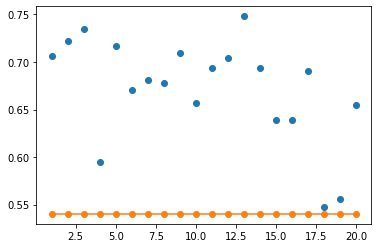

In [16]:
covnet.horizontal_voting(n_epoch=50, n_save_after=30)